# Plots for the 2MDM analysis

In [17]:
import warnings
warnings.filterwarnings("ignore", message="numpy.dtype size changed")
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from auxPlots import columnsDict, colorDict, defaultPars
import itertools

pd.option_context('display.max_columns', None)
pd.option_context('display.max_rows', None)

pd.options.mode.chained_assignment = None #Disable copy warnings

plt.rcParams.update(defaultPars) #Figure resolution

#### Get data in pcl format and print all columns names

In [18]:
#Merge with SModelS DataFrame
pclFiles = ['../data/smodels_results.pcl']
dfs = [pd.read_pickle(i) for i in pclFiles]
dataDF = pd.concat(dfs, ignore_index=True)
dataDF.rename(columns=columnsDict,inplace=True)
dropCols = [c for c in dataDF.columns if ('Output' in c or 'weight' in c)]
dataDF.drop(columns=dropCols,inplace=True)
dataDF.set_index('filename',drop=True,inplace=True)
print(dataDF.columns.values.tolist()) #Print all columns names

['mChi', 'mS', 'mZp', 'mass.9000002', 'mass.9000003', 'mass.9000004', 'mass.9000005', 'width.9000002', 'width.9000003', 'width.9000004', 'width.9000005', 'width.9000006', 'width.9900026', 'width.9900032', 'gchi', 'gq', 'sina', 'extpar.4', 'xsec8TeV(fb).9900032', 'xsec8TeV(fb).9900026', 'xsec13TeV(fb).9900032', 'xsec13TeV(fb).9900026', 'BRs.sd.W-,W+', 'BRs.sd.higgs,higgs', 'BRs.sd.Z,Z', 'BRs.sd.t-,t+', 'BRs.sd.chi,chi', 'BRs.sd.ta+,ta-', 'BRs.zp.chi,chi', 'BRs.zp.c,c', 'BRs.zp.q,q', 'BRs.zp.b,b', 'BRs.zp.t-,t+', 'totalxsec13TeV(fb)', 'totalxsec8TeV(fb)', 'CombinedRes', 'Total xsec for missing topologies (fb)', 'Total xsec for missing topologies with displaced decays (fb)', 'Total xsec for missing topologies with prompt decays (fb)', 'Total xsec for topologies outside the grid (fb)', 'ExptRes.result0.maxcond', 'ExptRes.result0.theory prediction (fb)', 'ExptRes.result0.upper limit (fb)', 'ExptRes.result0.expected upper limit (fb)', 'ExptRes.result0.TxNames', 'ExptRes.result0.Mass (GeV)', 

#### Filter couplings

In [19]:
gchi = 0.6
gq = 0.1
sina = 0.25
dataDF = dataDF[((dataDF['gchi'] == gchi) & (dataDF['gq'] == gq) & (dataDF['sina'] == sina))]

#### Set r = 0 for points with no results 

In [20]:
#Set points without results with r == 0
dataDF.fillna(value={c : 0 for c in dataDF.columns if c.endswith('.r')}, inplace=True)
#Sort points according to r value:
dataDF = dataDF.sort_values(by=['ExptRes.result0.r'],ascending=False)

### Split dataframe by analysis ID

In [21]:
# Get ExptRes columns and group according to ExptRes attribute
expResCols = np.array(sorted([c for c in dataDF.columns if 'ExptRes.' in c],key = lambda c: c.split('.')[-1]))
expCols = itertools.groupby(expResCols, key = lambda c: c.split('.')[-1])

# Get all analyses
idCols = np.array([c for c in dataDF.columns if 'AnalysisID' in c])
analysis = sorted(dataDF[idCols].stack().drop_duplicates().tolist())
# Get all Txnames
txCols = np.array([c for c in dataDF.columns if 'TxNames' in c and not 'weights' in c])
txnames = sorted(dataDF[txCols].stack().drop_duplicates().tolist())

# Merge all common ExptRes columns into single columns containing a list of results
newDataDF = dataDF.copy()
for key,group in expCols:
    g = list(group)
    newCol = f'ExptRes.result.{key}'
    newDataDF[newCol] = newDataDF[g].values.tolist()
    newDataDF.drop(columns=g,inplace=True)


# Now explode each list of values into distinct rows
expResColsNew = np.array(sorted([c for c in newDataDF.columns if 'ExptRes.' in c],key = lambda c: c.split('.')[-1]))
newDataDFexp = newDataDF.explode(list(expResColsNew))

# Finally group using analsysis IDs
anaGroups = newDataDFexp.groupby(by=['ExptRes.result.AnalysisID'])

In [22]:
anaDict = {ana[0] : anadf for ana,anadf in anaGroups}

#### Add combined analysis

In [23]:
# Create from CombinedRes dictionary:
dataCombinedDF = pd.DataFrame.from_dict([x[0] for x in dataDF[['CombinedRes']].dropna().squeeze()])
# Set index to match dataDF
dataCombinedDF.set_index(dataDF[~dataDF['CombinedRes'].isna()].index,inplace=True)
# Rename columns to match the standard naming
dataCombinedDF.rename(columns = {c : 'ExptRes.result.%s' %c for c in dataCombinedDF.columns.tolist()},inplace=True)
# Add non-exptres columns from dataDF:
dataCombinedDF = pd.concat([dataCombinedDF,dataDF[~dataDF['CombinedRes'].isna()].drop(columns=expResCols).drop(columns='CombinedRes')],axis=1)
# dataCombinedDF


In [24]:
anaDict['CombinedAna'] = dataCombinedDF

### Split analyses into MET and diquark (resonances)

In [25]:
# metAna = ['CMS-EXO-20-004','ATLAS-SUSY-2018-22','ATLAS-EXOT-2018-06'
#  'ATLAS-SUSY-2018-22-multibin','CombinedAna']
metAna = ['CombinedAna'] # Consider only the combination

diquarkAna = ['ATLAS-EXOT-2019-03', 'ATLAS-EXOT-2013-11', 'CMS-EXO-19-012', 
           'ATLAS-EXOT-2018-48', 'CMS-EXO-12-059', 'CMS-EXO-20-008', 
           'CMS-EXO-16-057']

In [26]:
diquarkDict = {ana : anadf for ana,anadf in anaDict.items() if ana in diquarkAna}
# metDict = {ana : anadf for ana,anadf in anaDict.items() if ana in metAna}
# use only the combination for comparison:
metDict = {ana : anadf for ana,anadf in anaDict.items() if ana in metAna}

### Compute the ratio max(r_met)/max(r_diquark)

In [27]:
metList = [df[['ExptRes.result.r','ExptRes.result.AnalysisID']] for df in metDict.values()]
# Contruct dataframe with one row for each analysis result (with duplicated indices)
rmax_met = pd.concat(metList)
# Sort the dataframe by the r-values
rmax_met = rmax_met.sort_values('ExptRes.result.r')
# Group by index and keep only the last entry for each index (filename),
# which corresponds to the largest r-value
rmax_met = rmax_met.groupby(rmax_met.index).last()
rmax_met.rename(columns={'ExptRes.result.r' : 'rmax_met'}, inplace=True)

In [28]:
diquarkList = [df[['ExptRes.result.r','ExptRes.result.AnalysisID']] for df in diquarkDict.values()]
# Contruct dataframe with one row for each analysis result (with duplicated indices)
rmax_diquark = pd.concat(diquarkList)
# Sort the dataframe by the r-values
rmax_diquark = rmax_diquark.sort_values('ExptRes.result.r')
# Group by index and keep only the last entry for each index (filename),
# which corresponds to the largest r-value
rmax_diquark = rmax_diquark.groupby(rmax_diquark.index).last()
rmax_diquark.rename(columns={'ExptRes.result.r' : 'rmax_diquark'}, inplace=True)

In [29]:
# Merge the dataframes and keep only entries where the ratio is available
rmaxDF = pd.concat([rmax_diquark,rmax_met,dataDF],axis=1)
rmaxDF['ratio'] = rmaxDF['rmax_met']/rmaxDF['rmax_diquark']
rmaxDF = rmaxDF[~rmaxDF['ratio'].isna()]
rmaxDF.sort_values(by='ratio',ascending=True,inplace=True)

### Get the largest overall r-value

In [30]:
# Contruct dataframe with one row for each analysis result (with duplicated indices)
rmax_all = pd.concat(metList+diquarkList)
# Sort the dataframe by the r-values
rmax_all = rmax_all.sort_values('ExptRes.result.r')
# Group by index and keep only the last entry for each index (filename),
# which corresponds to the largest r-value
rmax_all = rmax_all.groupby(rmax_all.index).last()
# Finally merge with dataDF without the ExptRes results
rmax_all = pd.concat([rmax_all,dataDF.drop(columns=list(expResCols)+['CombinedRes'])],axis=1)

# Plot Results

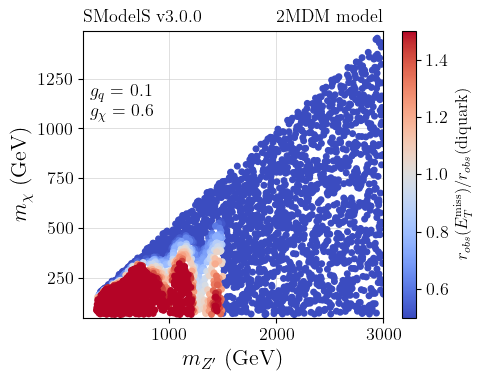

In [31]:
cm = sns.color_palette("coolwarm", as_cmap=True)

x = rmaxDF['mZp']
y = rmaxDF['mChi']
c = rmaxDF['ratio']
sc = plt.scatter(x,y,c=c, cmap=cm, vmin=0.5, vmax=1.5)

    

cb = plt.colorbar(sc)
cb.set_label(label=r'$r_{obs}(E_T^{\rm miss})$/$r_{obs}$(diquark)',fontsize=12)

plt.xlabel(r'$m_{Z^{\prime}}$ (GeV)')
plt.ylabel(r'$m_{\chi}$ (GeV)')
textstr = '\n'.join((
    r'$g_q =$ %1.1f' %gq, 
    r'$g_{\chi} = %1.1f$' %gchi))

plt.text(0.022,0.7,textstr,
         bbox=dict(facecolor='white', edgecolor='none'),transform = plt.gca().transAxes)

plt.title(r'SModelS v3.0.0', loc='left')
plt.title(r'2MDM model', loc='right')

plt.xlim(200, 3000)
plt.ylim(50, 1490)

plt.tight_layout()
plt.savefig('./figures/exclusions_2mdm_ratio_dij_monoj_c1.png')
plt.show()


3000 points plotted


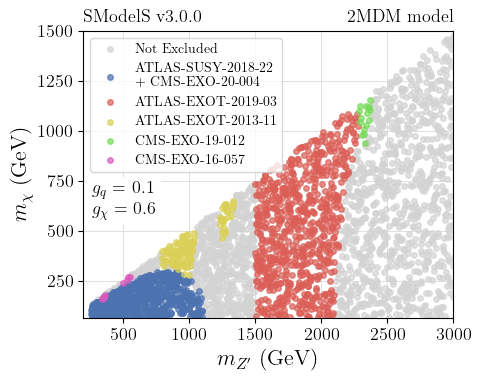

In [32]:
allowed = rmax_all[rmax_all['ExptRes.result.r'] < 1.0]
x = allowed['mZp']
y = allowed['mChi']
scAll = plt.scatter(x,y,color='lightgray', label='Not Excluded', alpha=0.7)
ntot = len(x)

# Use largest r-value result and group by analysis ID
rmax_groups = rmax_all.groupby(by='ExptRes.result.AnalysisID')

# Sort analyses by length of name and then length of points
for ana,anadf in sorted(rmax_groups, key = lambda x: (len(x[0]),len(x[1])),reverse=True):
    excludedAna = anadf[anadf['ExptRes.result.r'] > 1.0]
    if len(excludedAna) == 0:
        continue
    x = excludedAna['mZp']
    y = excludedAna['mChi']
    if ana in ['CombinedAna','ATLAS-SUSY-2018-22-multibin,CMS-EXO-20-004']:
        label = 'ATLAS-SUSY-2018-22'+'\n'+'+ CMS-EXO-20-004'
    else:
        label = ana
    sc = plt.scatter(x,y, color=colorDict[ana], label=label, alpha=0.7)
    ntot += len(x)


print(f'{ntot} points plotted')
plt.title(r'SModelS v3.0.0', loc='left')
plt.title(r'2MDM model', loc='right')


plt.xlabel(r'$m_{Z^{\prime}}$ (GeV)')
plt.ylabel(r'$m_{\chi}$ (GeV)')
textstr = '\n'.join((
    r'$g_q =$ %1.1f' %gq, 
    r'$g_{\chi} = %1.1f$' %gchi))

plt.text(0.022,0.36,textstr,
         bbox=dict(facecolor='white', edgecolor='none'),transform = plt.gca().transAxes)

plt.xlim(200, 3000)
plt.ylim(65, 1500)
plt.legend()
plt.tight_layout()
plt.savefig('./figures/exclusions_2mdm_NWA.png')
plt.show()